In [1]:
import matplotlib
import matplotlib.pyplot as plt
import torch
import numpy as np

from modules.operators.RadonTorch import RadonTorch
from modules.operators.Wavelet import Wavelet
import numpy as np
from modules.algorithm.ConjugateGradient import ConjugateGradient as CG
from modules.models.MetaInvNet import *
import torch
import torch_radon as tr

In [2]:
import os
import s3fs

In [3]:
# Create filesystem object
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})

In [4]:
BUCKET_X_TRUE_TRAIN = "antoinedp/x_true_train"
BUCKET_X_TRUE_TEST = "antoinedp/x_true_test"
BUCKET_X_FBP_TRAIN = "antoinedp/x_fbp_train"
BUCKET_X_FBP_TEST = "antoinedp/x_fbp_test"

x_true_train_filenames = fs.ls(BUCKET_X_TRUE_TRAIN)[1:]
x_true_test_filenames = fs.ls(BUCKET_X_TRUE_TEST)[1:]
x_fbp_train_filenames = fs.ls(BUCKET_X_FBP_TRAIN)[1:]
x_fbp_test_filenames = fs.ls(BUCKET_X_FBP_TEST)[1:]

In [5]:
import numpy as np

def import_data(file_paths):
    data = []
    for file_path in file_paths:
        with fs.open(file_path, mode="rb") as file_in:
            data.append(np.load(file_in, encoding="bytes"))
    return data
    
x_true_train = import_data(x_true_train_filenames[:100])
x_true_test = import_data(x_true_test_filenames[:100])
x_fbp_train = import_data(x_fbp_train_filenames[:100])
x_fbp_test = import_data(x_fbp_test_filenames[:100])


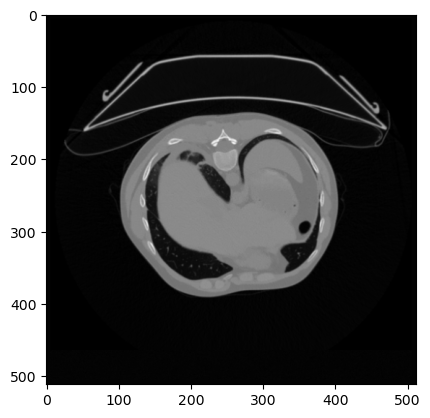

In [6]:
#!pip install matplotlib
from matplotlib import pyplot as plt
plt.imshow(x_true_train[18], cmap="gray")
plt.show()

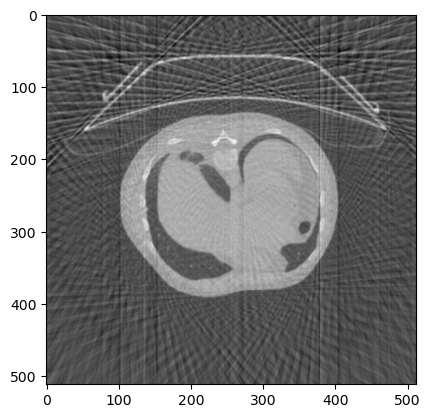

In [7]:
from matplotlib import pyplot as plt
plt.imshow(x_fbp_train[18], cmap="gray")
plt.show()

In [8]:
X_train, X_test, y_train, y_test = x_fbp_train, x_fbp_test, x_true_train, x_true_test

In [9]:
import numpy as np

# Stack the images along a new axis to calculate mean and std
stacked_x_train = np.stack(X_train, axis=0)
stacked_y_train = np.stack(y_train, axis=0)

# Calculate mean and std across all images
mean_x_train = np.mean(stacked_x_train)
std_x_train = np.std(stacked_x_train)
mean_y_train = np.mean(stacked_y_train)
std_y_train = np.std(stacked_y_train)

In [10]:
print(mean_x_train)
print(std_x_train)
print(mean_y_train)
print(std_y_train)

0.0038841886
0.007581674
0.003792319
0.0072153206


In [11]:
device = 'cuda'

X_train_tensor = torch.from_numpy(np.array(X_train)).to(dtype=torch.float32).to(device)
X_test_tensor = torch.from_numpy(np.array(X_test)).to(dtype=torch.float32).to(device)
y_train_tensor = torch.from_numpy(np.array(y_train)).to(dtype=torch.float32).to(device)
y_test_tensor = torch.from_numpy(np.array(y_test)).to(dtype=torch.float32).to(device)

In [12]:
angles = np.linspace(0, np.pi, 52, endpoint=False)
volume = tr.Volume2D()
volume.set_size(height=512, width=512)
radon = RadonTorch(512, angles, volume)
wavelet = Wavelet()

sinos_train = []
for xtrue_train in y_train_tensor:
    sinos_train.append(radon.transform(xtrue_train).to(device))

sinos_test = []
for xtrue_test in y_test_tensor:
    sinos_test.append(radon.transform(xtrue_test).to(device))

sinos_train_tensor = torch.stack(sinos_train)
sinos_test_tensor = torch.stack(sinos_test)

In [13]:
X_train_tensor = X_train_tensor.unsqueeze(1)
X_test_tensor = X_test_tensor.unsqueeze(1)
y_train_tensor = y_train_tensor.unsqueeze(1)
y_test_tensor = y_test_tensor.unsqueeze(1)
sinos_train_tensor = sinos_train_tensor.unsqueeze(1)
sinos_test_tensor = sinos_test_tensor.unsqueeze(1)

In [14]:
sinos_train_tensor = sinos_train_tensor.to(device)
sinos_test_tensor = sinos_test_tensor.to(device)

In [15]:
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader


normalize_x = transforms.Compose([
    transforms.Normalize(mean=[mean_x_train], std=[std_x_train])
])

normalize_y = transforms.Compose([
    transforms.Normalize(mean=[mean_y_train], std=[std_y_train])
])

class CustomDataset(Dataset):
    def __init__(self, im1, im2, im3):
        super(CustomDataset, self).__init__()
        self.im1 = im1
        self.im2 = im2
        self.im3 = im3

    def __getitem__(self, index):
        return self.im1[index,], self.im2[index,], self.im3[index,]

    def __len__(self):
        return len(self.im1)


dataloader_train = DataLoader(CustomDataset(sinos_train_tensor, X_train_tensor, y_train_tensor), batch_size=1, shuffle=True)
dataloader_test = DataLoader(CustomDataset(sinos_test_tensor, X_test_tensor, y_test_tensor), batch_size=1, shuffle=True)

/opt/mamba/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/opt/mamba/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c106detail23torchInternalAssertFailEPKcS2_jS2_RKSs'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [16]:
def train_loop(dataloader, model, loss_fn, optimizer, scheduler, device):
    size = len(dataloader.dataset)
    model.train()

    for batch, (sino, X, y) in enumerate(dataloader):
        sino = sino.to(device)
        X = X.to(device)
        y = y.to(device)
        # Compute prediction and loss
        pred = model(sino, X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Display loss from time to time
        if batch % 10 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss: >7f}  [{current: >5d} / {size: >5d}]")
    
    scheduler.step()
    



def test_loop(dataloader, model, loss_fn, device, set = "Test"):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for sino, X, y in dataloader:
            sino = sino.to(device)
            X = X.to(device)
            y = y.to(device)

            pred = model(sino, X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches
    print(f"\n{set} set: Avg loss: {test_loss: >8f} \n")
    return test_loss


def train(model, train_dataloader, test_dataloader, loss_fn, optimizer, scheduler, epochs, device):
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_dataloader, model, loss_fn, optimizer, scheduler, device)
        
        torch.save({'epoch': t,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'loss': loss_fn}, 
        	'./metainvnet.pth')
        
        test_loop(train_dataloader, model, loss_fn, device, set = "Training")
        test_loop(test_dataloader, model, loss_fn, device)

In [17]:
from torch.optim import lr_scheduler, SGD, Adam
import math
from modules.models.MetaInvNet import *

def ssim_loss(img1, img2, size=11,sigma = 1.5, cs_map=False):
    if isinstance(img1, torch.Tensor):
        img1 = img1.unsqueeze(0)
        img2 = img2.unsqueeze(0)

    window = fspecial_gauss(size, sigma)
    window = torch.from_numpy(window.copy()).unsqueeze(0).unsqueeze(0).type(torch.FloatTensor).cuda()
    window = torch.nn.Parameter(data=window, requires_grad=False)
    K1 = 0.001
    K2 = 0.03
    L = 2.0
    C1 = (K1 * L) ** 2
    C2 = (K2 * L) ** 2
    mu1 = F.conv2d(img1,window)
    mu2 = F.conv2d(img2,window)

    mu1_sq = mu1 * mu1
    mu2_sq = mu2 * mu2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = F.conv2d(img1 * img1, window )- mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window )- mu2_sq
    sigma12 = F.conv2d(img1 * img2, window )- mu1_mu2
    
    if cs_map:
        return (((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                             (sigma1_sq + sigma2_sq + C2)),
                (2.0 * sigma12 + C2) / (sigma1_sq + sigma2_sq + C2))
    else:
        ssim = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                            (sigma1_sq + sigma2_sq + C2))
        ssim = torch.clamp(ssim,min=0.0,max=1.0)
        return ssim.mean()

def l2loss_mean(x,y):
    assert x.size() == y.size()
    loss = torch.sum((x-y) ** 2)
    return loss

def fspecial_gauss(size, sigma):
    x, y = np.mgrid[-size // 2 + 1:size // 2 + 1, -size // 2 + 1:size // 2 + 1]
    g = np.exp(-((x ** 2 + y ** 2) / (2.0 * sigma ** 2)))
    return g / g.sum()


def loss_fun(db, sp):
    layer = len(db)
    loss = 0.0
    for ii in range(0, layer):
        loss =loss+ l2loss_mean(sp, db[ii]) * 1.1**ii
        for ii in range(0, layer):
            for jj in range(sp.shape[1]):
                img1=sp[jj,...]
                img2=db[ii][jj,...]

                ssim_value=1-ssim_loss(img1, img2,size=11,sigma = 1.5)
                loss=loss+ssim_value*100.0

        return loss

epochs = 100

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelMetaInv = MetaInvNetL(10, radon, wavelet).to(device)
optimizer = Adam(modelMetaInv.parameters(), lr=1e-3)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[30,40], gamma=0.9)
loss = loss_fun

train(model=modelMetaInv,
      train_dataloader=dataloader_train,
      test_dataloader=dataloader_test,
      loss_fn=loss,
      optimizer=optimizer,
      scheduler=scheduler,
      epochs=epochs,
      device=device)

Epoch 1
-------------------------------
loss: 2265.688477  [    1 /   100]
loss: 1110.420044  [   11 /   100]
loss: 988.703979  [   21 /   100]
loss: 913.724121  [   31 /   100]
loss: 961.184326  [   41 /   100]
loss: 890.476440  [   51 /   100]
loss: 954.185913  [   61 /   100]
loss: 827.602295  [   71 /   100]
loss: 871.818298  [   81 /   100]
loss: 866.644653  [   91 /   100]

Training set: Avg loss: 878.241486 


Test set: Avg loss: 880.783781 

Epoch 2
-------------------------------
loss: 884.341370  [    1 /   100]
loss: 891.660767  [   11 /   100]
loss: 979.772705  [   21 /   100]
loss: 983.510803  [   31 /   100]
loss: 960.402588  [   41 /   100]
loss: 897.149719  [   51 /   100]
loss: 876.553467  [   61 /   100]
loss: 882.342957  [   71 /   100]
loss: 828.018555  [   81 /   100]
loss: 794.418701  [   91 /   100]

Training set: Avg loss: 702.964836 


Test set: Avg loss: 700.477264 

Epoch 3
-------------------------------
loss: 710.218018  [    1 /   100]
loss: 791.602722  [ 

KeyboardInterrupt: 

In [ ]:

import torch
from torch import nn
from modules.algorithm.ConjugateGradient import ConjugateGradient
from modules.operators.Wavelet import Wavelet
from modules.operators.RadonTorch import RadonTorch
from modules.operators.Operator import Operator
import torch.nn.functional as F
import numpy as np

class Conv2dPReLU(nn.Module):

    def __init__(self, in_chan=1, out_chan=64):
        super(Conv2dPReLU, self).__init__()
        self.conv = nn.Conv2d(in_channels=in_chan, out_channels=out_chan, kernel_size=3, padding=1, bias=True)
        self.prelu = nn.PReLU(out_chan, init=0.025)

    def forward(self, x):
        x = self.prelu(self.conv(x))
        return x


class DnCNN(nn.Module):
    def __init__(self, depth=17, n_channels=64, in_chan=1, out_chan=1,add_bias=True):
        super(DnCNN, self).__init__()
        layers = [Conv2dPReLU(in_chan=in_chan, out_chan=n_channels)]
        for _ in range(depth-2):
            layers.append(Conv2dPReLU(in_chan=n_channels, out_chan=n_channels))
        layers.append(nn.Conv2d(in_channels=n_channels, out_channels=out_chan, kernel_size=3, padding=1, bias=True))
        self.dncnn = nn.Sequential(*layers)

    def forward(self, x):
        x = self.dncnn(x)
        return x

class MetaInvLOneIter(nn.Module):
    # One iteration of the HQS-CG algorithm
    def __init__(self):
        super(MetaInvLOneIter, self).__init__()
        self.CG = ConjugateGradient(10)
        self.CGInitDnCNN = DnCNN(depth=6, n_channels=8, in_chan=1, out_chan=1, add_bias=True)


    def forward(self, Y, xk_L, zk, lam_over_gamma , gamma, projection, wavelet):
    
        xkp1_0 = xk_L + self.CGInitDnCNN(xk_L)
        AtY = projection.transposed_transform(Y)

        gammaWtzk = gamma * wavelet.transposed_transform(zk)
        AtAxkp1_0 = projection.transposed_transform(projection.transform(xkp1_0))
        Wtwxkp1_0 = wavelet.transposed_transform(wavelet.transform(xkp1_0))
        residual = (AtAxkp1_0 + Wtwxkp1_0) - (AtY + gammaWtzk)
        # conjugate gradient
        xkp1_L = self.CG.solve(residual, xkp1_0, gamma, projection, wavelet)

        # soft tresholding
        Wxkp1_L = wavelet.transform(xkp1_L)
        zkp1 = F.relu(Wxkp1_L-lam_over_gamma) - F.relu(-Wxkp1_L-lam_over_gamma)

        return xkp1_L, zkp1



class MetaInvNetL(nn.Module):
    def __init__(self, layers, radon : Operator, wavelet : Operator):
        super(MetaInvNetL,self).__init__()
        self.layers = layers
        self.radon = radon
        self.wavelet = wavelet
        self.unrolled_net = nn.ModuleList()
        for i in range(self.layers + 1):
            self.unrolled_net.append(MetaInvLOneIter())
        

    def forward(self, y, xfbp):
        
        xk_list = [None] * (self.layers + 1)
        zk_list = [None] * (self.layers + 1)

        lambak = 0.005
        gammak = 0.01
        delta_lambda =0.0008
        delta_gamma = 0.02
        
        z0 = self.wavelet.transform(xfbp)
        xk_list[0], zk_list[0] = self.unrolled_net[0](y, xfbp, z0, lambak, gammak, self.radon, self.wavelet)

        for i in range(self.layers):
            lambak -= delta_lambda
            gammak -= delta_gamma
            xk_list[i+1], zk_list[i+1] = self.unrolled_net[i+1](y, xk_list[i], zk_list[i], lambak, gammak, self.radon, self.wavelet)
      
        return xk_list

In [ ]:
model = MetaInvNetL(5, radon, wavelet).to(device)

torch.autograd.set_detect_anomaly(True)
for batch, (sino, X, y) in enumerate(dataloader_train):
        print(f'---{batch}')
        sino = sino.to(device)
        X = X.to(device)
        y = y.to(device)

        # Compute prediction and loss
        pred = model(sino, X)
        loss = loss_fn(pred[5], y)

        # Backpropagation
        loss.backward()

---0
---1
---2
---3
---4
---5
---6
---7
---8
---9
---10
---11
---12


KeyboardInterrupt: 

In [18]:
sino, img_x, img_y = next(iter(dataloader_test))

In [19]:
sino, img_x, img_y = next(iter(dataloader_test))
z = modelMetaInv(sino, img_x)


In [22]:
print(z[10])

tensor([[[[ -25.8350,  -37.5584,  -52.3059,  ...,  -84.4477,  -74.4274,
            -53.0039],
          [ -55.8265,  -87.1120, -118.8517,  ..., -137.4627, -116.6418,
            -84.8373],
          [ -76.5236, -122.8010, -169.2483,  ..., -174.3072, -144.8172,
           -107.5704],
          ...,
          [ -76.4649, -136.5050, -193.2836,  ..., -182.5911, -134.5344,
            -89.7710],
          [ -51.5944,  -95.1497, -134.7514,  ..., -129.2741,  -95.3854,
            -63.2050],
          [ -21.7161,  -41.7641,  -61.0056,  ...,  -61.5263,  -45.2948,
            -31.6197]]]], device='cuda:0', grad_fn=<AddBackward0>)


In [ ]:
print(z.shape)

torch.Size([1, 1, 512, 512])


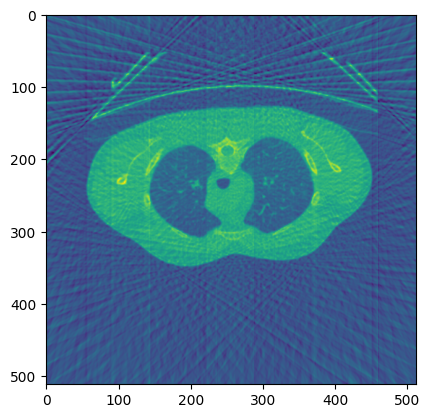

In [ ]:
img_x_, img_y_ = img_x[0].squeeze(0).squeeze(0).numpy(), img_y[0].squeeze(0).squeeze(0).numpy()
plt.imshow(img_x_)
plt.show()

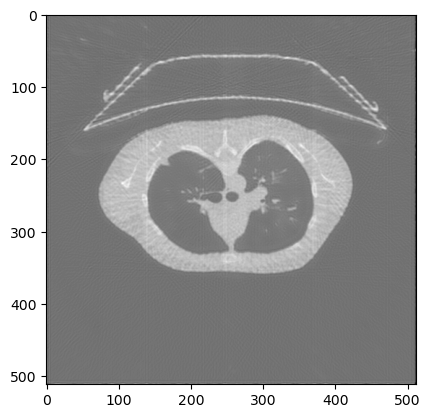

In [29]:
plt.imshow(z[1].squeeze(0).squeeze(0).to('cpu').detach().numpy(), cmap="gray")
plt.show()

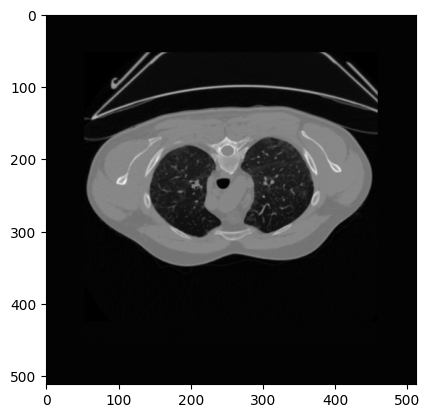

In [ ]:
plt.imshow(img_y_, cmap="gray")
plt.show()